In [3]:
import torch
import sys
import os
import json
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params
from dgl.geometry import farthest_point_sampler

sys.path.append("..")
from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import SingleEpochSpatialEdgeConstructor

/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/

In [4]:
VIS_METHOD = "tDVI" # DeepVisualInsight
CONTENT_PATH = "/home/xianglin/projects/DVI_data/resnet18_cifar10"
GPU_ID = "0"

In [5]:
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [6]:
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
VIS_MODEL = VISUALIZATION_PARAMETER['VIS_MODEL']
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

In [7]:
import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

In [8]:
# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name="Epoch", verbose=1)
if PREPROCESS:
    data_provider._meta_data()
    if B_N_EPOCHS >0:
        data_provider._estimate_boundary(LEN//10, l_bound=L_BOUND)

Finish initialization...


# try nas metric

In [ ]:
import torch.nn as nn
def get_layer_metric_array(network, metric, mode): 
    metric_array = []
    for layer in network.modules():
        if mode=='channel' and hasattr(layer,'dont_ch_prune'):
            continue
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            metric_array.append(metric(layer))
    
    return metric_array

In [ ]:
def grad_norm(layer):
    if layer.weight.grad is not None:
        return layer.weight.grad
    else:
        return torch.zeros_like(layer.weight)
def get_grad_norm_arr(network, data, loss_fn):
    network.to(device=DEVICE)
    network.train()
    network.zero_grad()

    # for data in self.edge_loader:\
    edge_to, edge_from, a_to, a_from = data

    edge_to = edge_to.to(device=DEVICE, dtype=torch.float32)
    edge_from = edge_from.to(device=DEVICE, dtype=torch.float32)
    a_to = a_to.to(device=DEVICE, dtype=torch.float32)
    a_from = a_from.to(device=DEVICE, dtype=torch.float32)

    outputs = network(edge_to, edge_from)
    _, _, loss = loss_fn(edge_to, edge_from, a_to, a_from, outputs)
    # ===================backward====================
    loss.backward()
    grad_norm_arr = get_layer_metric_array(network, grad_norm, mode='param')

    return grad_norm_arr

In [ ]:
def get_l2_norm_array(network):
    return get_layer_metric_array(network, lambda l: l.weight, mode="param")

In [ ]:
# snip
import types
import torch.nn.functional as F
def snip_forward_conv2d(self, x):
    return F.conv2d(x, self.weight * self.weight_mask, self.bias,
                    self.stride, self.padding, self.dilation, self.groups)
def snip_forward_linear(self, x):
    return F.linear(x, self.weight * self.weight_mask, self.bias)

def compute_snip_per_weight(network, data, loss_fn):
    for layer in network.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))
            layer.weight.requires_grad = False

        # Override the forward methods:
        if isinstance(layer, nn.Conv2d):
            layer.forward = types.MethodType(snip_forward_conv2d, layer)

        if isinstance(layer, nn.Linear):
            layer.forward = types.MethodType(snip_forward_linear, layer)

    # Compute gradients (but don't apply them)
    network.to(device=DEVICE)
    network.train()
    network.zero_grad()

    # for data in self.edge_loader:\
    edge_to, edge_from, a_to, a_from = data

    edge_to = edge_to.to(device=DEVICE, dtype=torch.float32)
    edge_from = edge_from.to(device=DEVICE, dtype=torch.float32)
    a_to = a_to.to(device=DEVICE, dtype=torch.float32)
    a_from = a_from.to(device=DEVICE, dtype=torch.float32)

    outputs = network(edge_to, edge_from)
    _, _, loss = loss_fn(edge_to, edge_from, a_to, a_from, outputs)
    # ===================backward====================
    
    loss.backward()

    # select the gradients that we want to use for search/prune
    def snip(layer):
        if layer.weight_mask.grad is not None:
            return torch.abs(layer.weight_mask.grad)
        else:
            return torch.zeros_like(layer.weight)
    
    grads_abs = get_layer_metric_array(network, snip, mode="param")

    return grads_abs

In [ ]:
import torch.autograd as autograd
def compute_grasp_per_weight(network, data, loss_fn):

    # get all applicable weights
    weights = []
    for layer in network.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            weights.append(layer.weight)
            layer.weight.requires_grad_(True) # TODO isn't this already true?

    # NOTE original code had some input/target splitting into 2
    # I am guessing this was because of GPU mem limit
    network.to(device=DEVICE)
    network.train()
    network.zero_grad()

    #forward/grad pass #1
    grad_w = None
    #TODO get new data, otherwise num_iters is useless!
    # for data in self.edge_loader:\
    edge_to, edge_from, a_to, a_from = data

    edge_to = edge_to.to(device=DEVICE, dtype=torch.float32)
    edge_from = edge_from.to(device=DEVICE, dtype=torch.float32)
    a_to = a_to.to(device=DEVICE, dtype=torch.float32)
    a_from = a_from.to(device=DEVICE, dtype=torch.float32)

    outputs = network(edge_to, edge_from)
    _, _, loss = loss_fn(edge_to, edge_from, a_to, a_from, outputs)
    
    grad_w_p = autograd.grad(loss, weights, allow_unused=True)
    if grad_w is None:
        grad_w = list(grad_w_p)
    else:
        for idx in range(len(grad_w)):
            grad_w[idx] += grad_w_p[idx]


    # forward/grad pass #2
    edge_to, edge_from, a_to, a_from = data

    edge_to = edge_to.to(device=DEVICE, dtype=torch.float32)
    edge_from = edge_from.to(device=DEVICE, dtype=torch.float32)
    a_to = a_to.to(device=DEVICE, dtype=torch.float32)
    a_from = a_from.to(device=DEVICE, dtype=torch.float32)

    outputs = network(edge_to, edge_from)
    _, _, loss = loss_fn(edge_to, edge_from, a_to, a_from, outputs)
    
    grad_f = autograd.grad(loss, weights, create_graph=True, allow_unused=True)
    
    # accumulate gradients computed in previous step and call backwards
    z, count = 0,0
    for layer in network.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            if grad_w[count] is not None:
                z += (grad_w[count].data * grad_f[count]).sum()
            count += 1
    z.backward()

    # compute final sensitivity metric and put in grads
    def grasp(layer):
        if layer.weight.grad is not None:
            return -layer.weight.data * layer.weight.grad   # -theta_q Hg
            #NOTE in the grasp code they take the *bottom* (1-p)% of values
            #but we take the *top* (1-p)%, therefore we remove the -ve sign
            #EDIT accuracy seems to be negatively correlated with this metric, so we add -ve sign here!
        else:
            return torch.zeros_like(layer.weight)
    
    grads = get_layer_metric_array(network, grasp, mode="param")

    return grads



In [ ]:
def get_sum(arr):
    s = 0.0
    for i in arr:
        s += i.sum().item()
    return s

In [ ]:
model = VisModel([512,256,2], [2,256,512])

## mutual info

In [ ]:
# p_data= data_provider.train_representation(1)
# n_data = data_provider.train_representation(2)

In [ ]:
# from pynndescent import NNDescent
# index = NNDescent(p_data, metric="cosine")
# neighbors = index.query(n_data, k=1)

In [ ]:
# dist = neighbors[1][:,0]

In [ ]:
# dist.max(), dist.mean(), dist.min()

## evaluate data

In [ ]:
I = 200
ratio = .1
strategy = "random" # "random"
# 200->0.125
# 100->0.14

In [ ]:
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)

# Define DVI Loss
criterion = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA1)

# Define training parameters
# Define Edge dataset
spatial_cons = SingleEpochSpatialEdgeConstructor(data_provider, I, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, metric="cosine")
train_data = data_provider.train_representation(I)
if strategy == "fps":
    # farthest point sampling
    data = torch.from_numpy(train_data[np.newaxis,:,:]).to(device=torch.device("cuda:1"))
    point_idxs = farthest_point_sampler(data, int(ratio*len(train_data)))
    point_idxs = point_idxs.cpu().numpy().squeeze(0)
    train_data = train_data[point_idxs]
else:
    # random sampling
    selected = np.random.choice(len(train_data), int(ratio*len(train_data)), replace=False)
    train_data = train_data[selected]
edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct(train_data)

probs = probs / (probs.max()+1e-3)
eliminate_zeros = probs>1e-2#1e-3
edge_to = edge_to[eliminate_zeros]
edge_from = edge_from[eliminate_zeros]
probs = probs[eliminate_zeros]

dataset = DataHandler(edge_to, edge_from, feature_vectors, attention)

n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(probs, n_samples, replacement=True)

In [ ]:
edge_loader = DataLoader(dataset, batch_size=1000, sampler=sampler)
print(I,  "All")
grasp_avg = 0
snip_avg = 0
c = 0
for data in edge_loader:
    c += 1 
    grasp_avg += get_sum(compute_grasp_per_weight(model, data, criterion))
    # print(f'grasp ratio:\t{ratio}\t', grasp)
    snip_avg += get_sum(compute_snip_per_weight(model, data, criterion))
    # print(f'snip ratio:\t{ratio}\t', snip_grad)
print(f'grasp ratio:\t{ratio}\t', grasp_avg/c)
print(f'snip ratio:\t{ratio}\t', snip_avg/c)
    

In [ ]:
print(I, strategy)
edge_loader = DataLoader(dataset, batch_size=1000, sampler=sampler)
grasp_avg = 0
snip_avg = 0
c = 0
for data in edge_loader:
    c += 1 
    grasp_avg += get_sum(compute_grasp_per_weight(model, data, criterion))
    # print(f'grasp ratio:\t{ratio}\t', grasp)
    snip_avg += get_sum(compute_snip_per_weight(model, data, criterion))
    # print(f'snip ratio:\t{ratio}\t', snip_grad)
print(f'grasp ratio:\t{ratio}\t', grasp_avg/c)
print(f'snip ratio:\t{ratio}\t', snip_avg/c)

# whether the boundary and the gap between two nearest samples are comparable

In [7]:
from pynndescent import NNDescent
def nn_dists(train_data, metric="euclidean"):
    # number of trees in random projection forest
    n_trees = min(64, 5 + int(round((train_data.shape[0]) ** 0.5 / 20.0)))
    # max number of nearest neighbor iters to perform
    n_iters = max(5, int(round(np.log2(train_data.shape[0]))))
    # distance metric
    # get nearest neighbors
    nnd = NNDescent(
        train_data,
        n_neighbors=10,
        metric=metric,
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=60,
        verbose=False
    )
    knn_indices, knn_dists = nnd.neighbor_graph
    return knn_dists[:, 1:].mean(axis=1)

In [8]:
I = 200

In [9]:
import time
from sklearn.neighbors import NearestNeighbors

train_data = data_provider.train_representation(I)
labels = data_provider.train_labels(I)
boundaries_dists = np.zeros((10,10))
t0 = time.time()
for s in range(10):
    for e in range(s+1, 10):
        cls_1 = train_data[labels==s]
        cls_2 = train_data[labels==e]
        n_neighbors = 10
        high_neigh = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
        high_neigh.fit(cls_1)
        dists_1, _ = high_neigh.kneighbors(cls_2, n_neighbors=n_neighbors, return_distance=True)
        boundaries_dists[s][e] = dists_1[:, 1:].mean(axis=1).mean()
        # print(s,e,boundaries_dists[s][e])
t1 = time.time()
print(f"{t1-t0:.2f}")

3.35


In [10]:
boundaries_dists = boundaries_dists+boundaries_dists.transpose()
boundaries_dists = boundaries_dists+np.eye(10)*boundaries_dists.max()
boundaries_dists.min()

4.230236614351321

In [11]:
train_data = data_provider.train_representation(I)
dists = nn_dists(train_data)
dists.mean()

0.10876794

In [44]:
ratio = .04
repeat = 10
m = np.zeros(repeat)
train_data = data_provider.train_representation(I)
# random sampling
for i in range(repeat):
    selected = np.random.choice(len(train_data), int(ratio*len(train_data)), replace=False)
    dists = nn_dists(train_data[selected])
    m[i] = dists.mean()
m.mean()

0.22365439981222152

## plot results

In [9]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [29]:
ratios = [0.0008, 0.001, 0.002, 0.003, 0.05, 0.1, 0.2,0.3,0.4,0.5, 0.6,0.7, 1.0]
# iterations = [10,100,200]
# content_path = "/home/xianglin/projects/DVI_data/resnet18_cifar10"
# iterations = [1,10,30,50]
content_path = "/home/xianglin/projects/DVI_data/resnet18_fmnist"
# iterations = [1,5,10,15]
# content_path = "/home/xianglin/projects/DVI_data/resnet18_mnist"

In [30]:
iteration = 1

accus_train = list()
accus_test = list()
ppr_train = list()
ppr_test = list()
for ratio in ratios:
    scripts = os.path.join(content_path, "Model", f"evaluation_singleDVI_{VIS_MODEL}_{ratio}.json")
    with open(scripts, "r") as f:
        eval = json.load(f)
    accus_train.append(eval["nn_train"][str(iteration)]["15"])
    accus_test.append(eval["nn_test"][str(iteration)]["15"])
    ppr_train.append(eval["ppr_train"][str(iteration)])
    ppr_test.append(eval["ppr_test"][str(iteration)])


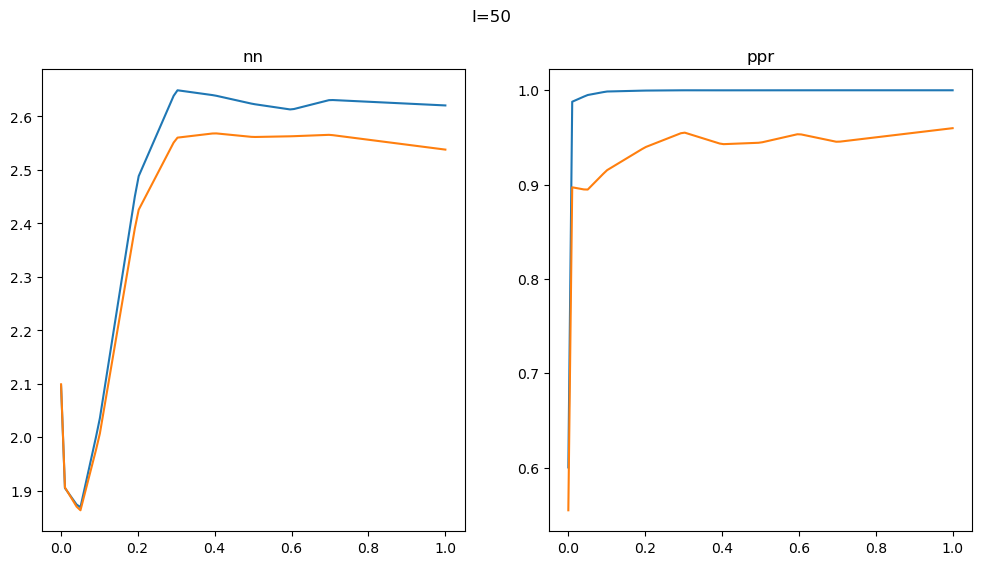

In [22]:
# Create an interpolation function
f1 = interp1d(ratios, accus_train, kind="linear")
f2 = interp1d(ratios, accus_test, kind="linear")
f3 = interp1d(ratios, ppr_train, kind="linear")
f4 = interp1d(ratios, ppr_test, kind="linear")

fig,ax = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(12, 6))

# Create a new x array with more points for a smoother plot
xnew = np.linspace(0.0008, 1.0, 100)
ax[0].set_title('nn')
ax[0].plot(xnew, f1(xnew),label="train")
ax[0].plot(xnew, f2(xnew),label="test")

ax[1].set_title('ppr')
ax[1].plot(xnew, f3(xnew),label="train")
ax[1].plot(xnew, f4(xnew),label="test")

fig.suptitle(f'I={iteration}')
plt.show()

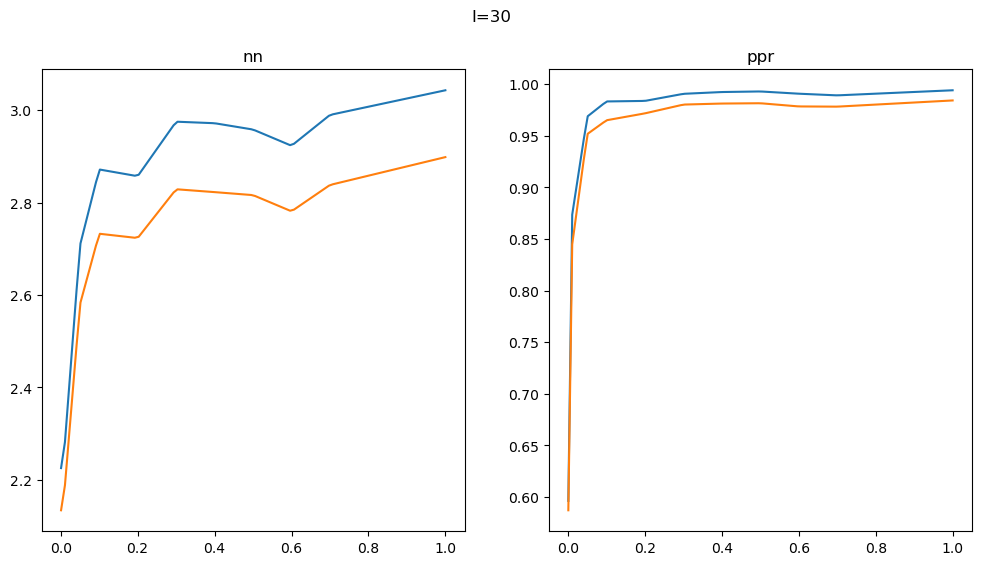

In [24]:
# Create an interpolation function
f1 = interp1d(ratios, accus_train, kind="linear")
f2 = interp1d(ratios, accus_test, kind="linear")
f3 = interp1d(ratios, ppr_train, kind="linear")
f4 = interp1d(ratios, ppr_test, kind="linear")

fig,ax = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(12, 6))

# Create a new x array with more points for a smoother plot
xnew = np.linspace(0.0008, 1.0, 100)
ax[0].set_title('nn')
ax[0].plot(xnew, f1(xnew),label="train")
ax[0].plot(xnew, f2(xnew),label="test")

ax[1].set_title('ppr')
ax[1].plot(xnew, f3(xnew),label="train")
ax[1].plot(xnew, f4(xnew),label="test")

fig.suptitle(f'I={iteration}')
plt.show()

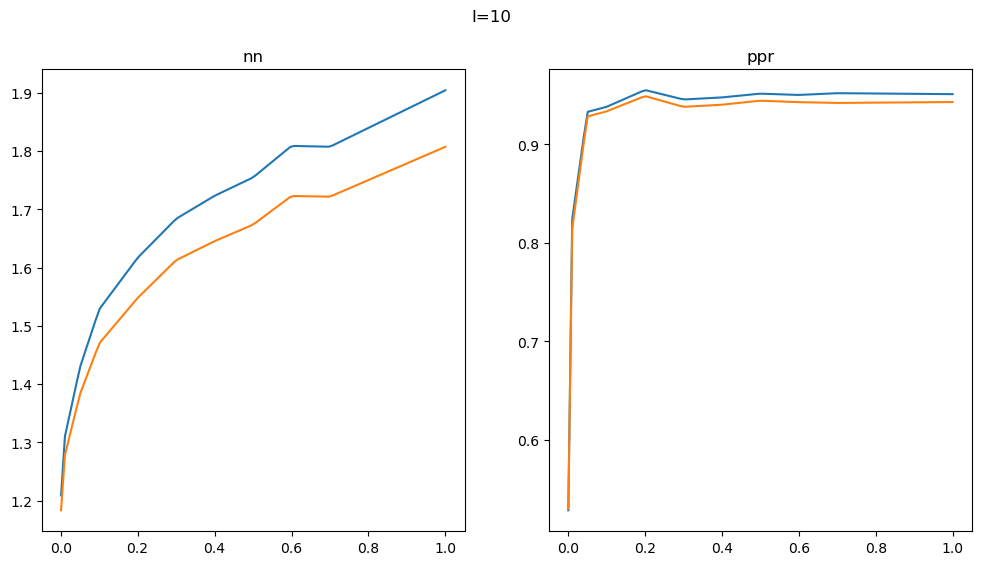

In [26]:
# Create an interpolation function
f1 = interp1d(ratios, accus_train, kind="linear")
f2 = interp1d(ratios, accus_test, kind="linear")
f3 = interp1d(ratios, ppr_train, kind="linear")
f4 = interp1d(ratios, ppr_test, kind="linear")

fig,ax = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(12, 6))

# Create a new x array with more points for a smoother plot
xnew = np.linspace(0.0008, 1.0, 100)
ax[0].set_title('nn')
ax[0].plot(xnew, f1(xnew),label="train")
ax[0].plot(xnew, f2(xnew),label="test")

ax[1].set_title('ppr')
ax[1].plot(xnew, f3(xnew),label="train")
ax[1].plot(xnew, f4(xnew),label="test")

fig.suptitle(f'I={iteration}')
plt.show()

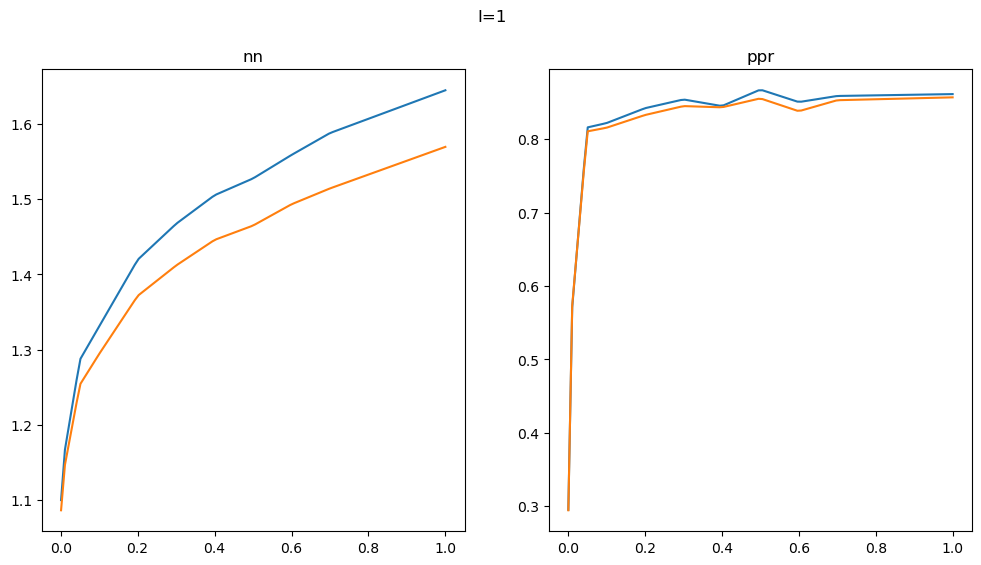

In [28]:
# Create an interpolation function
f1 = interp1d(ratios, accus_train, kind="linear")
f2 = interp1d(ratios, accus_test, kind="linear")
f3 = interp1d(ratios, ppr_train, kind="linear")
f4 = interp1d(ratios, ppr_test, kind="linear")

fig,ax = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(12, 6))

# Create a new x array with more points for a smoother plot
xnew = np.linspace(0.0008, 1.0, 100)
ax[0].set_title('nn')
ax[0].plot(xnew, f1(xnew),label="train")
ax[0].plot(xnew, f2(xnew),label="test")

ax[1].set_title('ppr')
ax[1].plot(xnew, f3(xnew),label="train")
ax[1].plot(xnew, f4(xnew),label="test")

fig.suptitle(f'I={iteration}')
plt.show()